# Predicting financial sentiment with word frequencies

In this notebook, we take a look at the routine of transforming text into numerical representation and train a model which uses this representation to predict the labeled sentiment of sentences. The methods, we demonstrate are:

* bag of words
* term-frequency inverse-document-frequency
* domain specific dictionaries

The next cell imports the financial phrasebank dataset. It consists of sentences from financial news which are labeled by sentiment. The data set includes 4080 sentences.

In [1]:
from datasets import load_dataset
import pandas as pd

# label 0: negative
# label 1: neutral
# label 2: positive
dataset = load_dataset("financial_phrasebank", "sentences_66agree")
fin_pb = pd.DataFrame(columns = ["sentence", "label"])
for i, item in enumerate(dataset["train"]):
    fin_pb.loc[i, :] = [item["sentence"], item["label"]]
fin_pb.loc[:, "label"] = fin_pb.label.astype(int)
fin_pb.head()

,sentence,label
0,"According to Gran , the company has no plans t...",1
1,Technopolis plans to develop in stages an area...,1
2,With the new production plant the company woul...,2
3,According to the company 's updated strategy f...,2
4,"For the last quarter of 2010 , Componenta 's n...",2


## Labels

The categories are rather unbalanced, with neutral being the label that occurs the most.

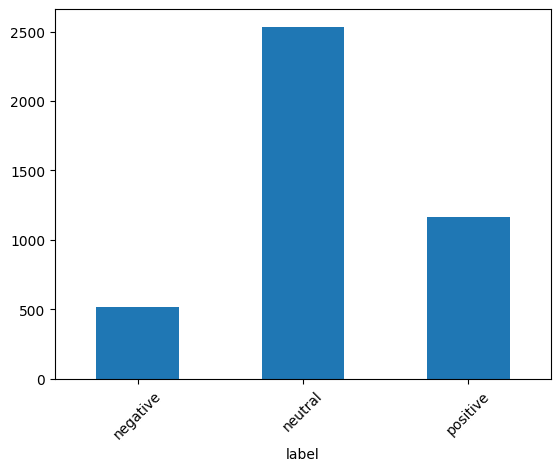

In [2]:
label_counts = fin_pb.groupby("label").size().to_frame("count").rename({0: "negative", 1: "neutral", 2: "positive"}).reset_index().plot.bar(x = "label", y = "count", legend = False, rot = 45)

## Example sentences

In [17]:
for idx, row in fin_pb.head().iterrows():
    print(row["sentence"])

According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .
Technopolis plans to develop in stages an area of no less than 100,000 square meters in order to host companies working in computer technologies and telecommunications , the statement said .
With the new production plant the company would increase its capacity to meet the expected increase in demand and would improve the use of raw materials and therefore increase the production profitability .
According to the company 's updated strategy for the years 2009-2012 , Basware targets a long-term net sales growth in the range of 20 % -40 % with an operating profit margin of 10 % -20 % of net sales .
For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .


### Neutral

In [52]:
for idx, row in fin_pb[fin_pb.label == 0].head().iterrows():
    print(row["sentence"])

Compared with the FTSE 100 index , which rose 94.9 points ( or 1.6 % ) on the day , this was a relative price change of -0.4 % .
Jan. 6 -- Ford is struggling in the face of slowing truck and SUV sales and a surfeit of up-to-date , gotta-have cars .
Peer Peugeot fell 0.81 pct as its sales rose only 6.3 pct from the same period last year .
Pharmaceuticals group Orion Corp reported a fall in its third-quarter earnings that were hit by larger expenditures on R&D and marketing .
However , the growth margin slowed down due to the financial crisis .


### Negative

In [53]:
for idx, row in fin_pb[fin_pb.label == 1].head().iterrows():
    print(row["sentence"])

According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .
Technopolis plans to develop in stages an area of no less than 100,000 square meters in order to host companies working in computer technologies and telecommunications , the statement said .
At the request of Finnish media company Alma Media 's newspapers , research manager Jari Kaivo-oja at the Finland Futures Research Centre at the Turku School of Economics has drawn up a future scenario for Finland 's national economy by using a model developed by the University of Denver .
In Sweden , Gallerix accumulated SEK denominated sales were down 1 % and EUR denominated sales were up 11 % .
The company supports its global customers in developing new technologies and offers a fast route from product development to applications and volume production .


### Positive

In [54]:
for idx, row in fin_pb[fin_pb.label == 2].head().iterrows():
    print(row["sentence"])

With the new production plant the company would increase its capacity to meet the expected increase in demand and would improve the use of raw materials and therefore increase the production profitability .
According to the company 's updated strategy for the years 2009-2012 , Basware targets a long-term net sales growth in the range of 20 % -40 % with an operating profit margin of 10 % -20 % of net sales .
For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .
In the third quarter of 2010 , net sales increased by 5.2 % to EUR 205.5 mn , and operating profit by 34.9 % to EUR 23.5 mn .
Operating profit rose to EUR 13.1 mn from EUR 8.7 mn in the corresponding period in 2007 representing 7.7 % of net sales .


## Word frequencies

The cells below demonstrate how to use the CountVectorizer and the TfidfVectorizer to create a document term matrix. We use a simple preprocessing routine and exclude stopwords. The maximum number of words to consider is defined as well. There is a trade-off, more words create higher dimensional representations of sentences, potentially creating problems for machine learning algorithms which are used afterwards. Less words may omit important information which is needed.

First, let us take a look how this works for the first five sentences, only.

In [2]:
from gensim.utils import simple_preprocess

preprocessed_sentences = [" ".join(simple_preprocess(sentence)) for sentence in fin_pb.sentence.iloc[:5]]
preprocessed_sentences

['according to gran the company has no plans to move all production to russia although that is where the company is growing',
 'technopolis plans to develop in stages an area of no less than square meters in order to host companies working in computer technologies and the statement said',
 'with the new production plant the company would increase its capacity to meet the expected increase in demand and would improve the use of raw materials and therefore increase the production profitability',
 'according to the company updated strategy for the years basware targets long term net sales growth in the range of with an operating profit margin of of net sales',
 'for the last quarter of componenta net sales doubled to eur from eur for the same period year earlier while it moved to zero pre tax profit from pre tax loss of eur']

To keep the dimension small, we set *min_df = 0.25*, to exclude terms whose document frequency occurrence is below this threshold. The cell below just shows how many times each of the remaining terms occurs in each sentence.

In [3]:
from sklearn.feature_extraction.text import CountVectorizer

# create the bag-of-words with default settings
vectorizer = CountVectorizer(stop_words="english", min_df = 0.25)
# the output is a sparse matrix, the first dimension are the number of reports, the second dimension is the number of terms
X = vectorizer.fit_transform(preprocessed_sentences)
# let us take a look at the first reports
feature_names = vectorizer.get_feature_names_out()
doc_mat_small = pd.DataFrame(X.toarray(), columns = feature_names)
doc_mat_small

,according,company,net,plans,production,profit,sales
0,1,2,0,1,1,0,0
1,0,0,0,1,0,0,0
2,0,1,0,0,2,0,0
3,1,1,2,0,0,1,2
4,0,0,1,0,0,1,1


The term-frequency inverse-document-frequency needs to determine inverse document frequencies, first. According to the [documentation](https://scikit-learn.org/1.5/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html), inverse frequency weights are determined by:

$$
id_j = \log \left(\frac{n}{n_j}\right) + 1
$$

if *smooth_idf=False*, and, 

$$
id_j = \log \left(\frac{1 + n}{1 + n_j}\right) + 1
$$

if *smooth_idf=False*. The inverse-document frequency is multiplied with the number each term appears in the document. Afterwards, scikit-learn normalizes these vectors to l2-norm by default. This is likely the default setting, because the cosine similarity between two l2-normalized vectors is simply their dot product. As cosine similarity is often used for text modeling, this normalization seems to be quite handy.


In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.utils import simple_preprocess

# create the bag-of-words with default settings
vectorizer = TfidfVectorizer(stop_words="english", min_df = 0.25, use_idf = True, norm = None)
# the output is a sparse matrix, the first dimension are the number of reports, the second dimension is the number of terms
X = vectorizer.fit_transform(preprocessed_sentences)
# let us take a look at the first reports
feature_names = vectorizer.get_feature_names_out()
doc_mat_idf_small = pd.DataFrame(X.toarray(), columns = feature_names)
doc_mat_idf_small

,according,company,net,plans,production,profit,sales
0,1.693147,2.810930,0.000000,1.693147,1.693147,0.000000,0.000000
1,0.000000,0.000000,0.000000,1.693147,0.000000,0.000000,0.000000
2,0.000000,1.405465,0.000000,0.000000,3.386294,0.000000,0.000000
3,1.693147,1.405465,3.386294,0.000000,0.000000,1.693147,3.386294
4,0.000000,0.000000,1.693147,0.000000,0.000000,1.693147,1.693147


The instance of the *TfidfVectorizer* stores inverse-document frequencies internally as shown below.

In [30]:
vectorizer.idf_

array([1.69314718, 1.40546511, 1.69314718, 1.69314718, 1.69314718,
       1.69314718, 1.69314718])

Let us determine the value for "according" manually. The term appears in two out of five documents, thus, with *smooth_idf=False*, the inverse-document frequency is:

In [93]:
import numpy as np

n = len(preprocessed_sentences)
n_j = np.sum(["according" in sentence for sentence in preprocessed_sentences])
id_j = np.log(n / n_j) + 1
id_j

1.916290731874155

Taking a look at the results from the *CountVectorizer* above, we see that the term "according" appears once in the first sentence, thus without normalization, the term-frequency inverse-document-frequency is simply:

In [94]:
n_ij = np.sum([word == "according" for word in preprocessed_sentences[0].split()])
n_ij * id_j

1.916290731874155

If we normalize the first vector by l2-normalization, we determine the l2-norm:

$$
\sqrt{\sum_k |x_k|^2}
$$

and divide each raw term-frequency inverse-document-frequeny by this norm.

In [109]:
doc_mat_idf_small.iloc[0].values / np.sqrt(doc_mat_idf_small.iloc[0].apply(lambda x: x**2).sum())

array([0.42693074, 0.6731942 , 0.        , 0.42693074, 0.42693074,
       0.        , 0.        ])

Let us include this step in the *TfidfVectorizer* and see the result.

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.utils import simple_preprocess

# create the bag-of-words with default settings
vectorizer = TfidfVectorizer(stop_words="english", min_df = 0.25, smooth_idf = False, norm = "l2")
# the output is a sparse matrix, the first dimension are the number of reports, the second dimension is the number of terms
X = vectorizer.fit_transform(preprocessed_sentences)
# let us take a look at the first reports
feature_names = vectorizer.get_feature_names_out()
doc_mat_idf_small = pd.DataFrame(X.toarray(), columns = feature_names)
doc_mat_idf_small

,according,company,net,plans,production,profit,sales
0,0.426931,0.673194,0.00000,0.426931,0.426931,0.000000,0.00000
1,0.000000,0.000000,0.00000,1.000000,0.000000,0.000000,0.00000
2,0.000000,0.366739,0.00000,0.000000,0.930324,0.000000,0.00000
3,0.306835,0.241912,0.61367,0.000000,0.000000,0.306835,0.61367
4,0.000000,0.000000,0.57735,0.000000,0.000000,0.577350,0.57735


Without going into the details, pairwise cosine similarities can be determined by the dot product multiplication of these l2-normalized vectors.

In [111]:
doc_mat_idf_small.values.dot(doc_mat_idf_small.values.transpose())

array([[1.        , 0.42693074, 0.64407043, 0.2938514 , 0.        ],
       [0.42693074, 1.        , 0.        , 0.        , 0.        ],
       [0.64407043, 0.        , 1.        , 0.08871871, 0.        ],
       [0.2938514 , 0.        , 0.08871871, 1.        , 0.88575692],
       [0.        , 0.        , 0.        , 0.88575692, 1.        ]])

Large values indicate similarity of the vectors. The highest similarity of sentence 1 is to sentence 3 which seems to meet the intuition if we compare their term-frequency inverse-document-frequencies. If you take a look at the sentences, this also seems to work as both sentences are about plans and company production. However, only as these terms are used with similar frequencies. This does not imply that these sentences need to have similar meaning or context. 

For later usage, we transform all sentences by the *CountVectorizer* and the *TfidfVectorizer* below.

In [161]:
from sklearn.feature_extraction.text import CountVectorizer
from gensim.utils import simple_preprocess

# create the bag-of-words with default settings
count_vectorizer = CountVectorizer(preprocessor = lambda x: " ".join(simple_preprocess(x)),max_features = 2000,  stop_words="english")
# the output is a sparse matrix, the first dimension are the number of reports, the second dimension is the number of terms
X = count_vectorizer.fit_transform(fin_pb.sentence)
# let us take a look at the first reports
feature_names = count_vectorizer.get_feature_names_out()
doc_mat = pd.DataFrame(X.toarray(), columns = feature_names)
doc_mat

,ab,able,abp,abroad,ac,access,accessories,accordance,according,account,...,yit,york,zinc,zone,àland,àm,ñinen,ñl,ñnnen,ñrvi
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4212,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4213,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4214,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4215,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.utils import simple_preprocess

# create the bag-of-words with default settings
vectorizer = TfidfVectorizer(preprocessor = lambda x: " ".join(simple_preprocess(x)), max_features=2000, stop_words="english", norm = None)
# the output is a sparse matrix, the first dimension are the number of reports, the second dimension is the number of terms
X = vectorizer.fit_transform(fin_pb.sentence)
# let us take a look at the first reports
feature_names = vectorizer.get_feature_names_out()
doc_mat_idf = pd.DataFrame(X.toarray(), columns = feature_names)
doc_mat_idf

,ab,able,abp,abroad,ac,access,accessories,accordance,according,account,...,yit,york,zinc,zone,àland,àm,ñinen,ñl,ñnnen,ñrvi
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.693156,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.693156,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4212,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4213,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4214,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4215,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Sentiment prediction

The cells below demonstrate how to train a random forest classifier which uses document term matrices that either use the count or inverse document frequencies of tokens. The confusion matrix exhibits that the classifier seems to do pretty well. Please note, that one should take care about aspects such as hyperparameter choice and cross validation to get a more meaningful analysis of the model performance.

## Trees and random forests

A random forest creates predictions by averaging predictions of decision trees which are trained on subsamples of a data set. A decision tree recursively partitions the feature space such that the samples with the same labels or similar target values are grouped together. A partition is called a node and the split points or rules to partition the nodes further are called edges. At some point the algorithm stops and we end up with the final nodes which are called leaves and can be used to predict the label. At each step, data is split such that a quality criterion is optimized, which is the lower the more pure the resulting partitions are with respect to a target variable. A more formal definition can be found [here](https://scikit-learn.org/1.5/modules/tree.html#mathematical-formulation). 

For instance, given a classification task as for our example, the "Gini" measure is used to quantify purity. Let $p_{mk}$ be the fraction of label $k$ in node $m$, e.g., $p_{m1} = 0.10$ if 10 out of 100 observations in node $m$ are of category $k=1$. The plot below illustrates how this measure becomes smaller the higher or lower the fraction of a category in a node ist. The lower the better, because we know with a higher level of certainty that an observation is or is not of category, given certain information provided by the features. 

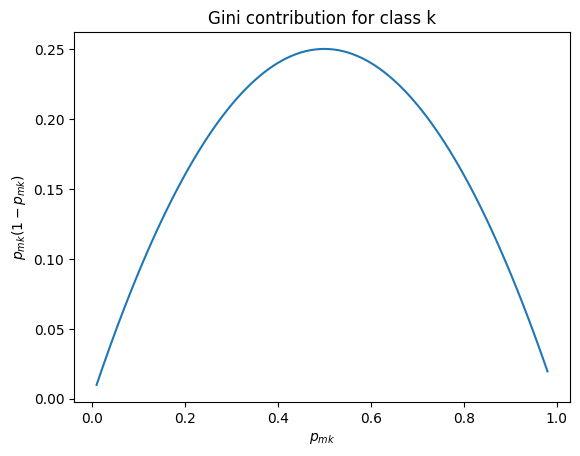

In [136]:
import numpy as np
import matplotlib.pylab as plt

p_mk = np.arange(0.01, 0.99, 0.01)
partial_gini = p_mk * (1 - p_mk)

plt.Figure()
plt.plot(p_mk, partial_gini)
plt.title("Gini contribution for class k")
plt.xlabel(r"$p_{mk}$")
plt.ylabel(r"$p_{mk}(1 - p_{mk})$")
plt.show()

The average purity is supposed to be recursively minimized for every partition of a tree until a stopping criterion is reached. See below an example for a decision tree which is stopped at a tree depth level of two.

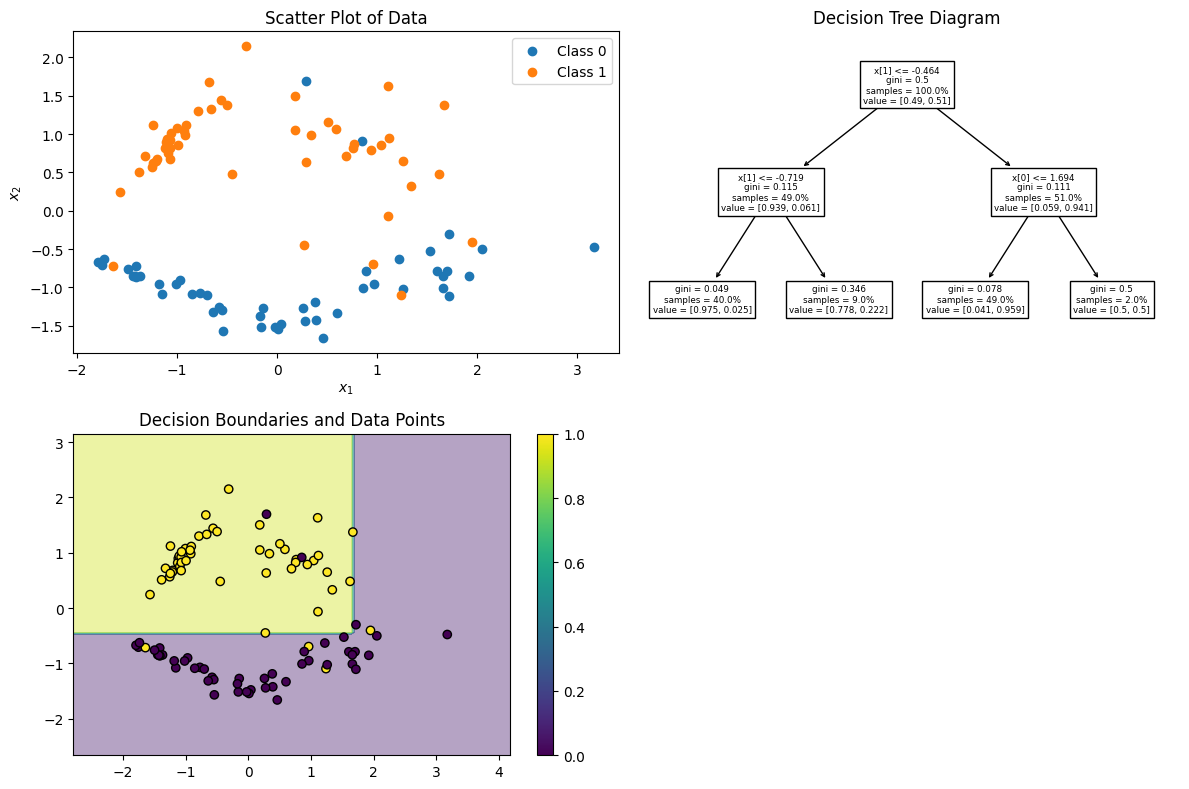

In [137]:
import numpy as np
from sklearn.datasets import make_classification
import matplotlib.pylab as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# Generate data
X, y = make_classification(n_features=2, n_informative=2, n_redundant=0, flip_y=0.10, random_state=1)

# Create a figure with subplots (2 rows, 2 columns)
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# 1st Plot: Scatter plot of the original data
axes[0, 0].scatter(X[y == 0][:, 0], X[y == 0][:, 1], label='Class 0')
axes[0, 0].scatter(X[y == 1][:, 0], X[y == 1][:, 1], label='Class 1')
axes[0, 0].set_xlabel(r"$x_1$")
axes[0, 0].set_ylabel(r"$x_2$")
axes[0, 0].set_title('Scatter Plot of Data')
axes[0, 0].legend()

# Fit the Decision Tree Classifier
classifier = DecisionTreeClassifier(max_depth=2)
classifier.fit(X, y)

# 2nd Plot: Decision tree diagram
tree.plot_tree(classifier, proportion=True, ax=axes[0, 1])
axes[0, 1].set_title('Decision Tree Diagram')

# Create a mesh grid for decision boundary plotting
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

# Predict values for each point on the grid
Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# 3rd Plot: Decision boundaries with data points
contour = axes[1, 0].contourf(xx, yy, Z, alpha=0.4, cmap='viridis')
scatter = axes[1, 0].scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', edgecolor='k')
axes[1, 0].set_title('Decision Boundaries and Data Points')
plt.colorbar(scatter, ax=axes[1, 0])

# Leave the 4th subplot (axes[1, 1]) empty
axes[1, 1].axis('off')  # This line turns off the axis, making it a blank subplot

# Adjust layout for clarity
plt.tight_layout()
plt.show()

## Financial sentiment with term frequencies and a random forest

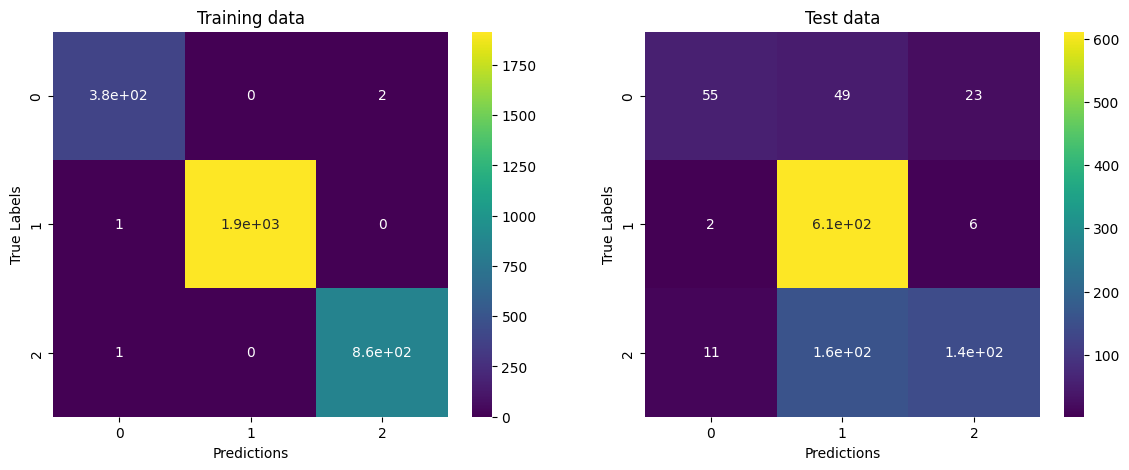

In [147]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pylab as plt
import seaborn as sns

clf = RandomForestClassifier(n_estimators=500, max_features="log2")

X = doc_mat.values
y = fin_pb.label.astype(int).values

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=42)
clf.fit(X_train, y_train)

cm_train = confusion_matrix(y_train, clf.predict(X_train), labels=clf.classes_)
cm_test = confusion_matrix(y_test, clf.predict(X_test), labels=clf.classes_)

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(cm_train, annot = True, cmap='viridis', ax = axs[0])

axs[0].set_xlabel('Predictions')
axs[0].set_ylabel('True Labels')
axs[0].set_title('Training data')

sns.heatmap(cm_test, annot = True, cmap='viridis', ax = axs[1])

axs[1].set_xlabel('Predictions')
axs[1].set_ylabel('True Labels')
axs[1].set_title('Test data')

plt.show()

## Financial sentiment with term frequencies and a random forest

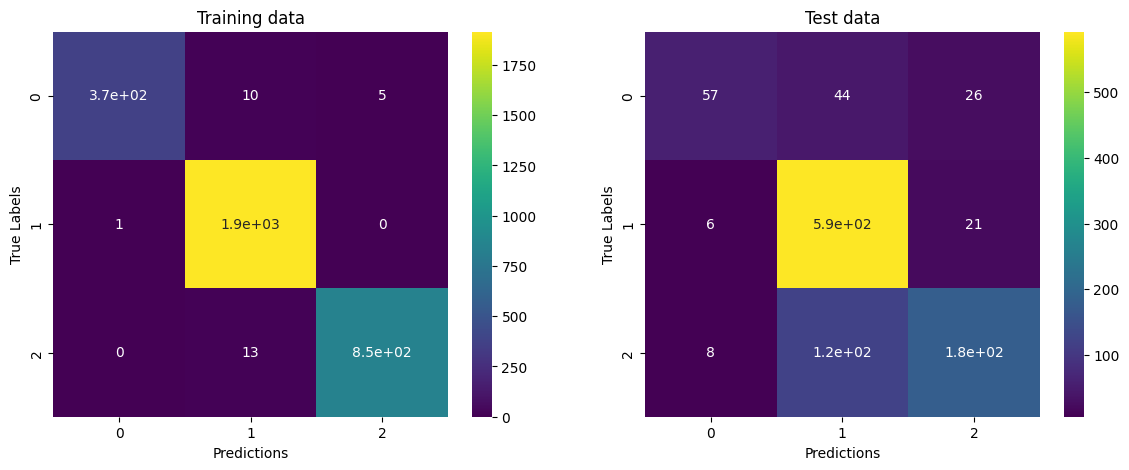

In [101]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pylab as plt
import seaborn as sns

clf = RandomForestClassifier(n_estimators=500, max_features="log2")

X = doc_mat_idf.values
y = fin_pb.label.astype(int).values

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=42)
clf.fit(X_train, y_train)

cm_train = confusion_matrix(y_train, clf.predict(X_train), labels=clf.classes_)
cm_test = confusion_matrix(y_test, clf.predict(X_test), labels=clf.classes_)

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(cm_train, annot = True, cmap='viridis', ax = axs[0])

axs[0].set_xlabel('Predictions')
axs[0].set_ylabel('True Labels')
axs[0].set_title('Training data')

sns.heatmap(cm_test, annot = True, cmap='viridis', ax = axs[1])

axs[1].set_xlabel('Predictions')
axs[1].set_ylabel('True Labels')
axs[1].set_title('Test data')

plt.show()